# Классификация токсичных комментариев с использованием BERT

## Импорты

In [48]:
%matplotlib inline

# стандартные библиотеки
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# модели машинного обучения
from sklearn.linear_model import LinearRegression

# токенизация
from transformers import BertTokenizer
# воспроизводимость
import torch
np.random.seed(42)
torch.manual_seed(42)


from collections import Counter
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import re


# константы
RANDOM_STATE = 42
TEST_SIZE = 0.2
MAX_LENGTH = 512

## Загрузка и осмотр данных

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\legonc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
try:
    df = pd.read_csv('notebooks/toxic_comments.csv')
    print('загружено локально')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
    print('загружено удаленно')

загружено удаленно



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

Первые 5 строк датасета:


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Статистики датасета:


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000



Пропуски в данных:
Unnamed: 0    0
text          0
toxic         0
dtype: int64

Количество дубликатов:
0


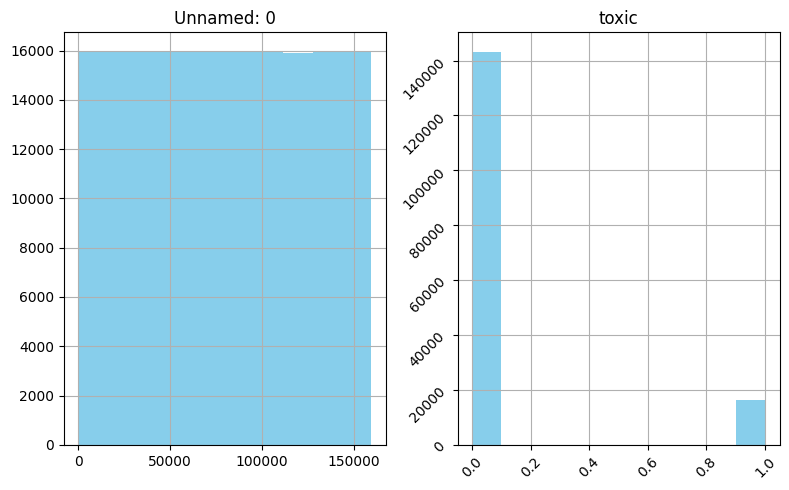

In [4]:
def check_df(df):
    print("\nИнформация о датасете:")
    display(df.info())
    print("Первые 5 строк датасета:")
    display(df.head())
    print("Статистики датасета:")
    display(df.describe())
    print("\nПропуски в данных:")
    print(df.isnull().sum())
    print("\nКоличество дубликатов:")
    print(df.duplicated().sum())

    df.hist(figsize=(8,5), color='skyblue')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

    print()

check_df(df)

In [5]:
# анализ длины текстов
df['text_length'] = df['text'].apply(len)
print("\nСтатистика длины текстов:")
print(df['text_length'].describe())


Статистика длины текстов:
count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64


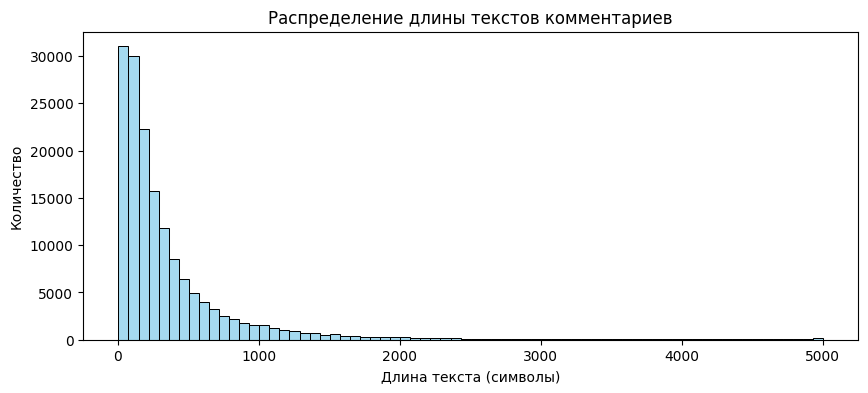

In [6]:
# визуализация распределения длины текстов
plt.figure(figsize=(10, 4))
sns.histplot(df['text_length'], bins=70, color='skyblue')
plt.title('Распределение длины текстов комментариев')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество')
plt.show()

**Выводы по загрузке и анализу данных**
- Датасет содержит 159292 строки, столбцы: `text`, `toxic`.
- Столбец `Unnamed: 0` удалю как избыточный.
- Пропуски и дубликаты отсутствуют.
- Распределение классов: ~90% нетоксичных, ~10% токсичных (дисбаланс).
- Для просмотра длины текста был создан столбец `text_length`.
- Длина текстов: средняя ~393 символа, медиана ~205, максимум 5000 (явно выброс, нужно проверить) (BERT принимает до 512 токенов, нужно будет что-то делать с длинными текстами).
- **Следующий шаг**: Исследовательский анализ данных

## EDA + предобработка

Для начала удалю избыточный столбец

In [7]:
df = df.drop(columns=['Unnamed: 0'])
df.shape, df.columns

((159292, 3), Index(['text', 'toxic', 'text_length'], dtype='object'))

In [8]:
# повторно проверим распределение классов
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

### Анализ длины текстов

In [9]:
df['text_length'].describe()

count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64

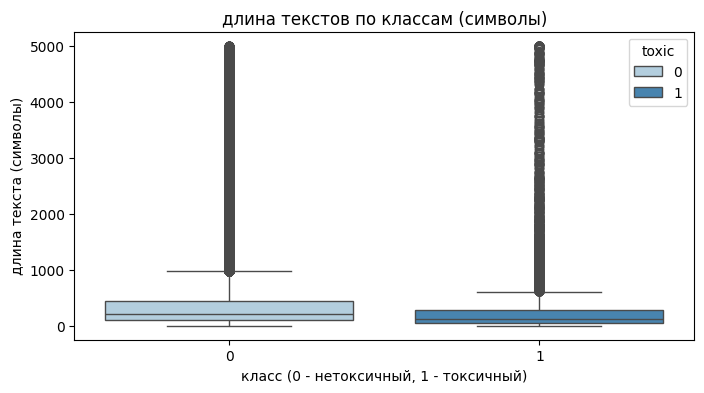

In [10]:
# boxplot длины по классам
plt.figure(figsize=(8, 4))
sns.boxplot(x='toxic', y=df['text'].str.len(), hue='toxic', data=df, palette='Blues')
plt.title('длина текстов по классам (символы)')
plt.xlabel('класс (0 - нетоксичный, 1 - токсичный)')
plt.ylabel('длина текста (символы)')
plt.show()

в данных достаточно много длинных комментариев

In [11]:
df.query('text_length > 500').count()

text           33851
toxic          33851
text_length    33851
dtype: int64

комментов длиннее 500 символов почти пятая часть от всех данных

In [12]:
def get_top_words_and_ngrams(texts, top_n=30, ngram_range=(1, 1)):
    # Получение топ-слов
    if ngram_range == (1, 1):
        vec = CountVectorizer(lowercase=True, stop_words='english')
    else:
        vec = CountVectorizer(ngram_range=ngram_range, lowercase=True, stop_words='english')

    bag = vec.fit_transform(texts)
    sums = bag.sum(axis=0)
    freqs = [(word, sums[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    top_words = sorted(freqs, key=lambda x: x[1], reverse=True)[:top_n]
    
    return top_words

In [13]:
toxic_texts = df[df['toxic'] == 1]['text']
non_toxic_texts = df[df['toxic'] == 0]['text']

print("\nТоп-30 слов в токсичных комментариях:")
get_top_words_and_ngrams(toxic_texts)


Топ-30 слов в токсичных комментариях:


[('fuck', np.int64(9988)),
 ('wikipedia', np.int64(3919)),
 ('like', np.int64(3798)),
 ('shit', np.int64(3688)),
 ('fucking', np.int64(3320)),
 ('nigger', np.int64(3306)),
 ('suck', np.int64(3245)),
 ('ass', np.int64(3001)),
 ('don', np.int64(2840)),
 ('just', np.int64(2738)),
 ('hate', np.int64(2655)),
 ('page', np.int64(2368)),
 ('know', np.int64(2364)),
 ('gay', np.int64(2262)),
 ('die', np.int64(2141)),
 ('people', np.int64(2057)),
 ('faggot', np.int64(2025)),
 ('fat', np.int64(1981)),
 ('moron', np.int64(1886)),
 ('bitch', np.int64(1834)),
 ('hi', np.int64(1712)),
 ('cunt', np.int64(1570)),
 ('article', np.int64(1569)),
 ('talk', np.int64(1539)),
 ('stop', np.int64(1509)),
 ('stupid', np.int64(1488)),
 ('wiki', np.int64(1478)),
 ('sucks', np.int64(1447)),
 ('user', np.int64(1413)),
 ('think', np.int64(1397))]

В данных очень много бесполезных слов, например, артиклей, местоимений. Также слова сами по себе не очень информативны, посмотрим n-граммы и долю капса (это признак токсичности обычно).

In [14]:
# Топ-30 биграмм в токсичных комментариях
print("\nТоп-30 биграмм в токсичных комментариях:")
display(get_top_words_and_ngrams(toxic_texts, ngram_range=(2, 2)))

# Топ-30 триграмм в токсичных комментариях
print("\nТоп-30 триграмм в токсичных комментариях:")
get_top_words_and_ngrams(toxic_texts, ngram_range=(3, 3))


Топ-30 биграмм в токсичных комментариях:


[('fuck fuck', np.int64(2959)),
 ('nigger nigger', np.int64(2149)),
 ('hate hate', np.int64(1570)),
 ('moron hi', np.int64(1474)),
 ('hi moron', np.int64(1472)),
 ('pig pig', np.int64(1250)),
 ('jew fat', np.int64(1234)),
 ('fat jew', np.int64(1226)),
 ('shit shit', np.int64(1149)),
 ('suck suck', np.int64(1136)),
 ('ass ass', np.int64(1127)),
 ('bark bark', np.int64(999)),
 ('wanker wanker', np.int64(963)),
 ('bullshit bullshit', np.int64(833)),
 ('balls balls', np.int64(833)),
 ('nipple nipple', np.int64(763)),
 ('faggot faggot', np.int64(755)),
 ('talk page', np.int64(737)),
 ('die die', np.int64(643)),
 ('dickhead dickhead', np.int64(625)),
 ('die fag', np.int64(625)),
 ('fag die', np.int64(624)),
 ('faggots faggots', np.int64(624)),
 ('fucksex fucksex', np.int64(623)),
 ('fuck yourselfgo', np.int64(621)),
 ('yourselfgo fuck', np.int64(621)),
 ('aids aids', np.int64(592)),
 ('freedom freedom', np.int64(572)),
 ('super gay', np.int64(501)),
 ('gay super', np.int64(499))]


Топ-30 триграмм в токсичных комментариях:


[('fuck fuck fuck', np.int64(2825)),
 ('nigger nigger nigger', np.int64(2139)),
 ('hate hate hate', np.int64(1547)),
 ('hi moron hi', np.int64(1468)),
 ('moron hi moron', np.int64(1466)),
 ('pig pig pig', np.int64(1248)),
 ('fat jew fat', np.int64(1226)),
 ('jew fat jew', np.int64(1224)),
 ('ass ass ass', np.int64(1124)),
 ('suck suck suck', np.int64(1116)),
 ('shit shit shit', np.int64(1107)),
 ('bark bark bark', np.int64(998)),
 ('wanker wanker wanker', np.int64(960)),
 ('balls balls balls', np.int64(831)),
 ('bullshit bullshit bullshit', np.int64(828)),
 ('nipple nipple nipple', np.int64(761)),
 ('faggot faggot faggot', np.int64(749)),
 ('die fag die', np.int64(624)),
 ('fag die fag', np.int64(624)),
 ('faggots faggots faggots', np.int64(623)),
 ('fucksex fucksex fucksex', np.int64(622)),
 ('fuck yourselfgo fuck', np.int64(621)),
 ('yourselfgo fuck yourselfgo', np.int64(619)),
 ('dickhead dickhead dickhead', np.int64(618)),
 ('freedom freedom freedom', np.int64(570)),
 ('die die die

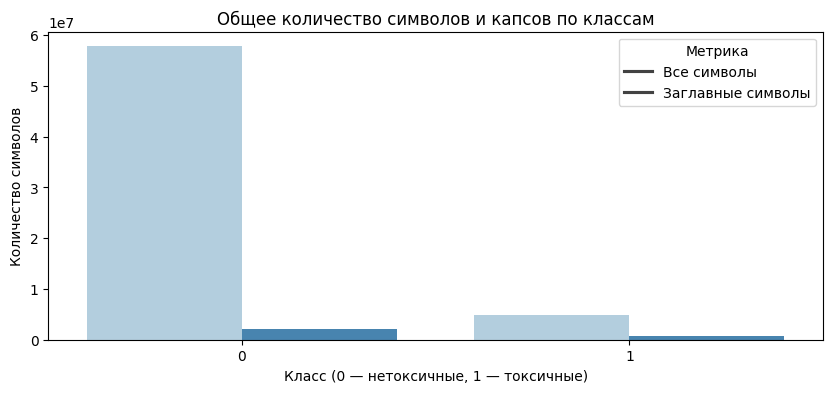

,toxic,metric,count
0,0,total_chars,57808611
1,1,total_chars,4903264
2,0,caps_chars,2035255
3,1,caps_chars,696383


In [15]:
# считаем количество символов и капсов по классам
df['total_chars'] = df['text'].str.len()
df['caps_chars'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))

agg = df.groupby('toxic')[['total_chars', 'caps_chars']].sum().reset_index()

# визуализация
agg_melted = agg.melt(id_vars='toxic', value_vars=['total_chars', 'caps_chars'],
                      var_name='metric', value_name='count')

plt.figure(figsize=(10,4))
sns.barplot(x='toxic', y='count', hue='metric', data=agg_melted, palette='Blues')
plt.title('Общее количество символов и капсов по классам')
plt.xlabel('Класс (0 — нетоксичные, 1 — токсичные)')
plt.ylabel('Количество символов')
plt.legend(title='Метрика', labels=['Все символы', 'Заглавные символы'])
plt.show()
agg_melted

- В биграммах и триграммах очень много слов повторяются, нужно проверить, почему.
- Отношение капслоковых слов к общему количеству не очень большое, можно все слова привести в нижний регистр.

посмотрим, сколько из необработанных текстов сможет принять берт

### Токенизация комментариев

In [16]:
# анализ длины в токенах
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_lengths = []
for text in tqdm(df['text'], desc="токенизация"):
    tokens = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
    token_lengths.append(len(tokens))

df['text_token_length'] = token_lengths
print("\nстатистика длины текстов (токены):")
print(df['text_token_length'].describe())

токенизация: 100%|██████████| 159292/159292 [02:30<00:00, 1061.64it/s]


статистика длины текстов (токены):
count    159292.000000
mean         88.134307
std         102.500119
min           4.000000
25%          26.000000
50%          52.000000
75%         104.000000
max         512.000000
Name: text_token_length, dtype: float64


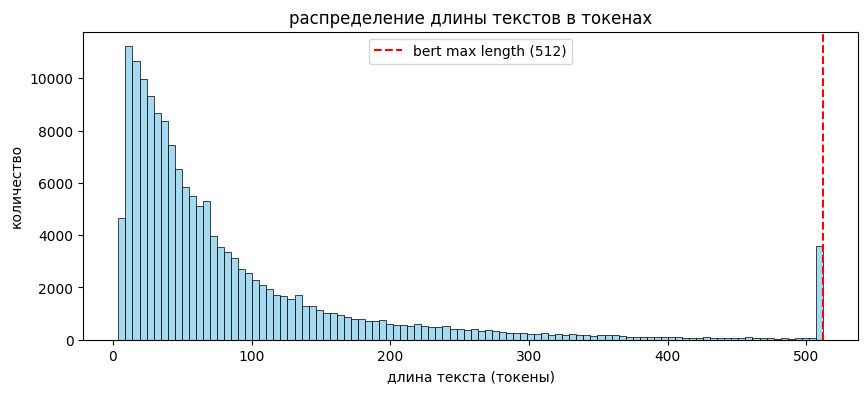

In [17]:
# гистограмма длины в токенах
plt.figure(figsize=(10, 4))
sns.histplot(df['text_token_length'], bins=100, color='skyblue')
plt.title('распределение длины текстов в токенах')
plt.xlabel('длина текста (токены)')
plt.ylabel('количество')
plt.axvline(x=512, color='red', linestyle='--', label='bert max length (512)')
plt.legend()
plt.show()

токенайзер просто обрезал большинство текстов до 512 токенов. поработаем с качеством текстов.

### Обработка текстов

- загрузим стопслова
- удалим пунктуацию
- удалим все не-ascii символы
- приведем все тексты в нижний регистр

In [18]:
# загружаем stopwords
stop_words = set(stopwords.words('english'))

# проверяем не-ascii перед удалением
non_ascii = df[df['text'].str.contains('[^\x00-\x7F]', regex=True, na=False)]
print(f"тексты с не-ascii символами: {len(non_ascii)} ({len(non_ascii)/len(df)*100:.2f}%)")

# проверяем caps ratio (доля заглавных букв) перед lowercase
def calc_caps_ratio(text):
    if not text:
        return 0
    total_chars = len(text)
    caps_chars = sum(1 for c in text if c.isupper())
    return caps_chars / total_chars if total_chars > 0 else 0

df['caps_ratio'] = df['text'].apply(calc_caps_ratio)
print("\nстатистика caps ratio по классам:")
display(df.groupby('toxic')['caps_ratio'].describe())

# функция очистки текста
def clean_text(text):
    # переводим в нижний регистр
    text = text.lower()
    # удаляем не-ascii
    text = re.sub(r'[^\x00-\x7F]', '', text)
    # удаляем пунктуацию
    text = re.sub(r'[^\w\s]', '', text)
    # удаляем stopwords
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

# применяем очистку
df['clean_text'] = df['text'].apply(clean_text)

тексты с не-ascii символами: 17178 (10.78%)

статистика caps ratio по классам:


,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,143106.0,0.044905,0.065405,0.0,0.020833,0.031579,0.047619,0.962963
1,16186.0,0.110978,0.207466,0.0,0.019380,0.034682,0.068042,0.998189


In [19]:
toxic_texts = df[df['toxic'] == 1]['clean_text']
non_toxic_texts = df[df['toxic'] == 0]['clean_text']

print("\nТоп-30 слов в токсичных комментариях:")
get_top_words_and_ngrams(toxic_texts)


Топ-30 слов в токсичных комментариях:


[('fuck', np.int64(8662)),
 ('dont', np.int64(3877)),
 ('like', np.int64(3759)),
 ('shit', np.int64(3647)),
 ('wikipedia', np.int64(3473)),
 ('nigger', np.int64(3295)),
 ('fucking', np.int64(3222)),
 ('suck', np.int64(3044)),
 ('ass', np.int64(2652)),
 ('hate', np.int64(2636)),
 ('know', np.int64(2341)),
 ('page', np.int64(2328)),
 ('gay', np.int64(2245)),
 ('im', np.int64(2223)),
 ('die', np.int64(2136)),
 ('fat', np.int64(1978)),
 ('people', np.int64(1974)),
 ('faggot', np.int64(1962)),
 ('youre', np.int64(1925)),
 ('moron', np.int64(1885)),
 ('hi', np.int64(1709)),
 ('cunt', np.int64(1555)),
 ('article', np.int64(1535)),
 ('stop', np.int64(1485)),
 ('stupid', np.int64(1473)),
 ('sucks', np.int64(1445)),
 ('bitch', np.int64(1432)),
 ('think', np.int64(1392)),
 ('talk', np.int64(1380)),
 ('jew', np.int64(1349))]

In [20]:
# проверяем пустые тексты после очистки
empty_clean = df[df['clean_text'].str.strip().eq('')]
print(f"\nпустые тексты после очистки: {len(empty_clean)}")


пустые тексты после очистки: 21


In [21]:
df.head(20)

,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text
0,Explanation\nWhy the edits made under my usern...,0,264,264,17,68,0.064394,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,112,112,8,35,0.071429,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,233,233,4,54,0.017167,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,622,622,11,144,0.017685,cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",0,67,67,2,21,0.029851,sir hero chance remember page thats
5,"""\n\nCongratulations from me as well, use the ...",0,65,65,1,17,0.015385,congratulations well use tools well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,44,44,37,12,0.840909,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,115,115,4,31,0.034783,vandalism matt shirvington article reverted pl...
8,Sorry if the word 'nonsense' was offensive to ...,0,472,472,7,119,0.014831,sorry word nonsense offensive anyway im intend...
9,alignment on this subject and which are contra...,0,70,70,2,17,0.028571,alignment subject contrary dulithgow


In [22]:
df['clean_text_length'] = df['clean_text'].apply(len)
print("\nСтатистика длины текстов:")
df['clean_text_length'].describe()


Статистика длины текстов:


count    159292.000000
mean        254.377897
std         395.470121
min           0.000000
25%          60.000000
50%         131.000000
75%         278.000000
max        5000.000000
Name: clean_text_length, dtype: float64

In [23]:
df.query('clean_text_length >= 1500')

,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text,clean_text_length
10,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,2875,2875,53,512,0.018435,fair use rationale imagewonjujpg thanks upload...,1829
50,"""\n\nBI, you said you wanted to talk\n\nAt the...",0,3150,3150,78,512,0.024762,bi said wanted talk bottom lead section writte...,2272
81,"""\n\nIs it scientific to attribute an event A,...",0,2749,2749,83,512,0.030193,scientific attribute event cause b cause b del...,1716
126,"Ahh, Hello Witzeman \n\n203.92.84.161 \nSymbo...",0,4364,4364,271,512,0.062099,ahh hello witzeman 2039284161 symbols characte...,2070
160,"""== Attributing and classifying of personaliti...",0,3958,3958,121,512,0.030571,attributing classifying personalities invitati...,2930
...,...,...,...,...,...,...,...,...,...
159127,Heres the talkpage discussion - that Jehocman ...,0,2647,2647,129,512,0.048734,heres talkpage discussion jehocman blocked hi ...,1599
159138,"""\n\n News suppressed on Wikipedia http://rexc...",0,4833,4833,168,512,0.034761,news suppressed wikipedia httprexcurrynetwikip...,3415
159164,"""\nI understand you, but you also should under...",0,2262,2262,123,512,0.054377,understand also understand shouldnt revert wor...,1505
159180,"""\n\n Evidence Redux \n\nI'll be frank. The b...",0,3508,3508,66,512,0.018814,evidence redux ill frank blocking came bit lat...,2194


Комментарии состоящие из одного или нескольких повторяющихся слов, чередования слов, например, know fggt know fggt, и длиннее 1000-1500 символов, думаю, можно отнести к спаму и избавиться от них или обработать, например, сжать подряд идущие слова и устранить чередования.

### Обработка спама

In [24]:
# функция для подсчёта уникальности слов
def uniqueness_score(text):
    if not isinstance(text, str) or not text:
        return 1.0
    words = text.split()
    return len(set(words)) / len(words) if words else 1.0

# доработанная функция collapse_repeats
def collapse_repeats(text, max_repeats=5):
    if not isinstance(text, str) or not text:
        return ''
    
    # разбиваем на слова
    words = text.split()
    result = []
    seen_pairs = {}  # словарь для отслеживания чередующихся пар (A B A B)
    
    i = 0
    while i < len(words):
        # проверяем пары слов
        if i + 1 < len(words):
            pair = (words[i].lower(), words[i + 1].lower())
            if pair in seen_pairs:
                seen_pairs[pair] += 1
                if seen_pairs[pair] > max_repeats:
                    i += 2  # пропускаем повторяющуюся пару
                    continue
            else:
                seen_pairs[pair] = 1
            result.extend([words[i], words[i + 1]])
            i += 2
        else:
            result.append(words[i])
            i += 1
    
    return ' '.join(result)

In [25]:
df['text_length'] = df['clean_text'].str.len()
df['uniqueness'] = df['clean_text'].apply(uniqueness_score)
potential_spam = df[df['uniqueness'] < 0.5]
print(f"\nпотенциальный спам (уникальность <50%): {len(potential_spam)} ({len(potential_spam)/len(df)*100:.2f}%)")
if len(potential_spam) > 0:
    print("\nраспределение классов в потенциальном спаме:")
    print(potential_spam['toxic'].value_counts(normalize=True))
    print("\nпримеры потенциального спама:")
    print(potential_spam[['text', 'clean_text']].head(5))


потенциальный спам (уникальность <50%): 761 (0.48%)

распределение классов в потенциальном спаме:
toxic
1    0.516426
0    0.483574
Name: proportion, dtype: float64

примеры потенциального спама:
                                                   text  \
505   2010 Meet a Local - Vietnam TV Series, Factual...   
788   Other Bush articles not referenced in George W...   
1043  "\n\nOrphaned non-free image (Image:KSV Hessen...   
1303  "\nWrong licenses\nI have corrected the licens...   
1336  I AM GAY\nLove\n  \nI AM GAY\nLove\n  \nI AM G...   

                                             clean_text  
505   2010 meet local vietnam tv series factual docu...  
788   bush articles referenced george w bush none fo...  
1043  orphaned nonfree image imageksv hessen kasselp...  
1303  wrong licenses corrected licenses majority ima...  
1336                         gay love gay love gay love  


In [26]:
# применяем сжатие чередующихся повторов
df['clean_text'] = df['clean_text'].apply(lambda x: collapse_repeats(x, max_repeats=2))

In [27]:
# проверяем результат
df['clean_text_length'] = df['clean_text'].str.len()
print(f"\nстатистика длины текстов после сжатия:")
print(df['clean_text_length'].describe())
print(f"\nтексты длиннее 512 символов после сжатия: {len(df[df['clean_text_length'] > 512])} ({len(df[df['clean_text_length'] > 512])/len(df)*100:.2f}%)")

empty_clean = df[df['clean_text'].str.strip().eq('')]
print(f"\nпустые тексты после сжатия: {len(empty_clean)} ({len(empty_clean)/len(df)*100:.2f}%)")
if len(empty_clean) > 0:
    print("\nраспределение классов в пустых текстах:")
    print(empty_clean['toxic'].value_counts(normalize=True))
    df = df[~df['clean_text'].str.strip().eq('')]


статистика длины текстов после сжатия:
count    159292.000000
mean        248.057122
std         371.017989
min           0.000000
25%          60.000000
50%         130.000000
75%         275.000000
max        4965.000000
Name: clean_text_length, dtype: float64

тексты длиннее 512 символов после сжатия: 18191 (11.42%)

пустые тексты после сжатия: 21 (0.01%)

распределение классов в пустых текстах:
toxic
0    0.952381
1    0.047619
Name: proportion, dtype: float64


In [28]:
df.query('clean_text_length <= 10')

,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text,clean_text_length,uniqueness
259,Y r we doing this: Pat,0,5,22,2,9,0.090909,r pat,5,1.0
627,Seems we both have some.,0,5,24,1,8,0.041667,seems,5,1.0
807,You are \n\nso retarded.,1,8,22,1,9,0.045455,retarded,8,1.0
852,P.S. Are you a /b/tard?,1,8,23,3,15,0.130435,ps btard,8,1.0
899,I've just seen that,0,8,19,1,8,0.052632,ive seen,8,1.0
...,...,...,...,...,...,...,...,...,...,...
158791,!!! \nDOWN WITH THE USA!!!,1,3,25,14,12,0.560000,usa,3,1.0
158964,wtf \n\n your a queer,1,9,20,0,7,0.000000,wtf queer,9,1.0
159169,Yeah i no it sucks.,1,10,19,1,8,0.052632,yeah sucks,10,1.0
159193,You ignored him too,0,7,19,1,6,0.052632,ignored,7,1.0


stopwords, конечно, довольно сильно подрезал предложения, но, семантику, вроде, потеряли не слишком сильно, ключевые положительные и негативные слова, в большинстве своем, остались.
далее можно удалить строки с комментариями короче 3 символов и посчитать длины текстов в токенах с помощью токенайзера берт.

In [29]:
df = df.query('clean_text_length > 3')

проверим качество обработки спама:

In [30]:
toxic_texts = df[df['toxic'] == 1]['clean_text']
non_toxic_texts = df[df['toxic'] == 0]['clean_text']

In [31]:
# Топ-30 слов в токсичных комментариях
print("\nТоп-30 слов в токсичных комментариях:")
print(get_top_words_and_ngrams(toxic_texts))

# Топ-30 биграмм в токсичных комментариях
print("\nТоп-30 биграмм в токсичных комментариях:")
print(get_top_words_and_ngrams(toxic_texts, ngram_range=(2, 2)))

# Топ-30 триграмм в токсичных комментариях
print("\nТоп-30 триграмм в токсичных комментариях:")
print(get_top_words_and_ngrams(toxic_texts, ngram_range=(3, 3)))


Топ-30 слов в токсичных комментариях:
[('fuck', np.int64(3329)), ('dont', np.int64(3280)), ('like', np.int64(3099)), ('wikipedia', np.int64(2642)), ('fucking', np.int64(2274)), ('page', np.int64(2211)), ('im', np.int64(2017)), ('people', np.int64(1904)), ('know', np.int64(1831)), ('youre', np.int64(1671)), ('shit', np.int64(1606)), ('article', np.int64(1529)), ('think', np.int64(1389)), ('stop', np.int64(1373)), ('talk', np.int64(1267)), ('stupid', np.int64(1184)), ('time', np.int64(1142)), ('want', np.int64(1069)), ('ass', np.int64(1061)), ('life', np.int64(1041)), ('make', np.int64(977)), ('bitch', np.int64(954)), ('edit', np.int64(923)), ('really', np.int64(901)), ('little', np.int64(891)), ('block', np.int64(874)), ('right', np.int64(849)), ('say', np.int64(809)), ('going', np.int64(802)), ('good', np.int64(800))]

Топ-30 биграмм в токсичных комментариях:
[('talk page', np.int64(613)), ('dont know', np.int64(321)), ('piece shit', np.int64(244)), ('im going', np.int64(193)), ('fuck

совершенно неплохо. количество повторов в н-граммах очень сильно снизилось, хоть и не полностью, но какое-то количество допустимо, так как при агрессивной обработке повторов можно потерять семантику текстов.

### Токенизация чистых комментов

In [32]:
# анализ длины в токенах
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_lengths = []
for text in tqdm(df['clean_text'], desc="токенизация"):
    tokens = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
    token_lengths.append(len(tokens))

df['token_length'] = token_lengths
print("\nстатистика длины текстов (токены):")
print(df['token_length'].describe())

токенизация: 100%|██████████| 159239/159239 [01:29<00:00, 1788.45it/s]


статистика длины текстов (токены):
count    159239.000000
mean         46.080100
std          63.153953
min           3.000000
25%          14.000000
50%          26.000000
75%          51.000000
max         512.000000
Name: token_length, dtype: float64


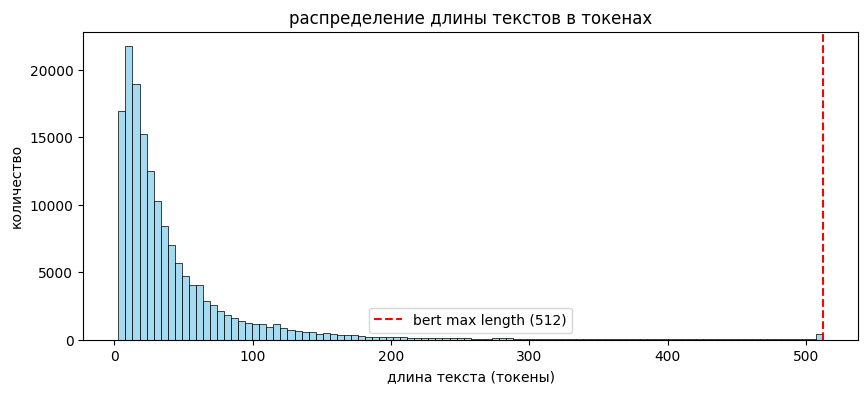

In [33]:
# гистограмма длины в токенах
plt.figure(figsize=(10, 4))
sns.histplot(df['token_length'], bins=100, color='skyblue')
plt.title('распределение длины текстов в токенах')
plt.xlabel('длина текста (токены)')
plt.ylabel('количество')
plt.axvline(x=512, color='red', linestyle='--', label='bert max length (512)')
plt.legend()
plt.show()

обработка текстов показала себя хорошо. мы потеряли минимум данных и при этом токенайзер не просто обрезал комментарии на 512 токенах, как в необработанных текстах. почти все тексты влезли в необходимый порог. Далее посмотрим корреляции и зависимости.

## Корреляционный анализ


корреляция Пирсона:


,caps_ratio,clean_text_length,token_length,uniqueness,toxic,text_length,total_chars,caps_chars
caps_ratio,1.000000,-0.095778,-0.086532,-0.015129,0.214987,-0.043195,-0.057872,0.310289
clean_text_length,-0.095778,1.000000,0.982545,-0.505409,-0.084531,0.943450,0.954644,0.197935
token_length,-0.086532,0.982545,1.000000,-0.509078,-0.073891,0.928889,0.942517,0.192931
uniqueness,-0.015129,-0.505409,-0.509078,1.000000,0.009347,-0.588640,-0.585243,-0.328607
toxic,0.214987,-0.084531,-0.073891,0.009347,1.000000,-0.048388,-0.051740,0.090100
text_length,-0.043195,0.943450,0.928889,-0.588640,-0.048388,1.000000,0.989913,0.403906
total_chars,-0.057872,0.954644,0.942517,-0.585243,-0.051740,0.989913,1.000000,0.370251
caps_chars,0.310289,0.197935,0.192931,-0.328607,0.090100,0.403906,0.370251,1.000000


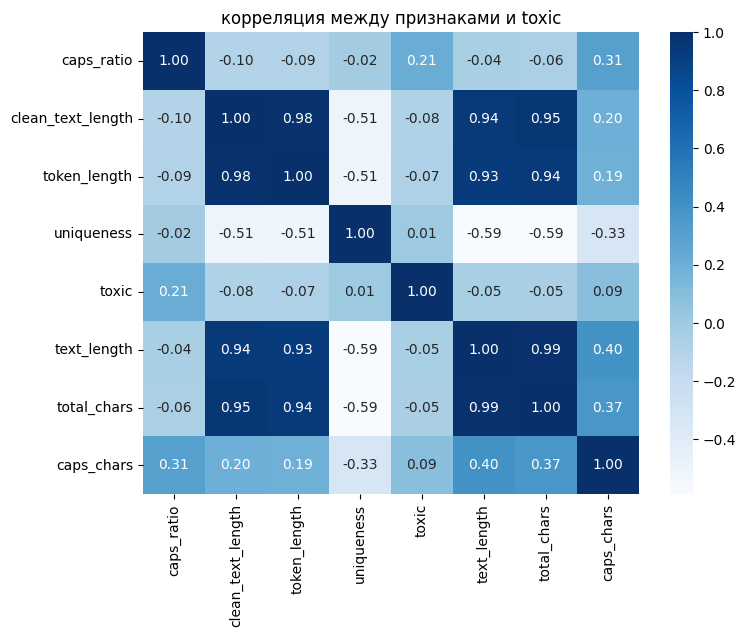

In [55]:
# корреляция между числовыми признаками и toxic
corr_matrix = df[['caps_ratio', 
                  'clean_text_length', 
                  'token_length', 
                  'uniqueness', 
                  'toxic', 
                  'text_length', 
                  'total_chars', 
                  'caps_chars',
                  ]].corr(method='pearson')
print("\nкорреляция Пирсона:")
display(corr_matrix)

# визуализация корреляционной матрицы
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('корреляция между признаками и toxic')
plt.show()

- **Корреляция Пирсона**:  
  - `caps_ratio` имеет умеренную положительную корреляцию с `toxic` (r=0.2150), что подтверждает: токсичные тексты чаще содержат заглавные буквы.  
  - `clean_text_length` и `token_length` слабо отрицательно коррелируют с `toxic` (r=-0.0845 и r=-0.0739), указывая, что токсичные тексты слегка короче.  
  - `uniqueness` имеет почти нулевую корреляцию с `toxic` (r=0.0093), то есть уникальность слов не влияет на токсичность.  
  - Высокая корреляция между `clean_text_length` и `token_length` (r=0.9825) ожидаема, так как они измеряют длину текста. 


точечная биссериальная корреляция для caps_ratio:
корреляция: 0.2150, p-value: 0.0000

точечная биссериальная корреляция для clean_text_length:
корреляция: -0.0845, p-value: 0.0000

точечная биссериальная корреляция для token_length:
корреляция: -0.0739, p-value: 0.0000

точечная биссериальная корреляция для uniqueness:
корреляция: 0.0093, p-value: 0.0002


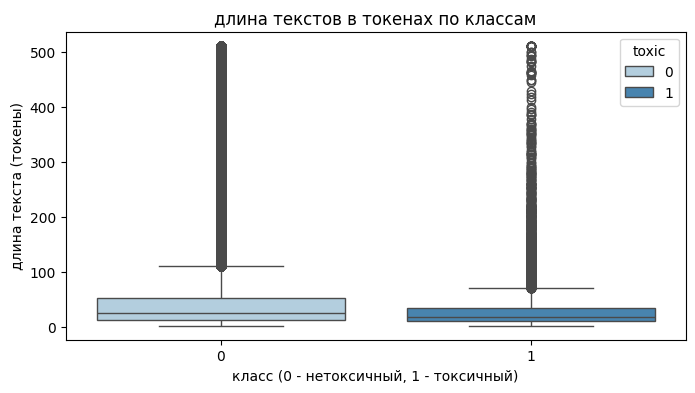

In [38]:
# точечная биссериальная корреляция для toxic (бинарный)
for feature in ['caps_ratio', 'clean_text_length', 'token_length', 'uniqueness']:
    corr, p_value = pointbiserialr(df[feature], df['toxic'])
    print(f"\nточечная биссериальная корреляция для {feature}:")
    print(f"корреляция: {corr:.4f}, p-value: {p_value:.4f}")

# boxplot для token_length по классам
plt.figure(figsize=(8, 4))
sns.boxplot(x='toxic', y='token_length', hue='toxic', data=df, palette='Blues')
plt.title('длина текстов в токенах по классам')
plt.xlabel('класс (0 - нетоксичный, 1 - токсичный)')
plt.ylabel('длина текста (токены)')
plt.show()

- **Точечная биссериальная корреляция**:  
  - Подтверждает выводы Пирсона: `caps_ratio` (r=0.2150, p=0.0000) хорошо связан с токсичностью, `clean_text_length` и `token_length` имеют слабую связь, `uniqueness` почти не влияет (p=0.0002, но r=0.0093).
- **Boxplot `token_length`**:  
  - Токсичные тексты имеют меньшую медианную длину (около 40 токенов) по сравнению с нетоксичными (около 50 токенов), но разница небольшая.

In [40]:
# анализ частоты токсичных слов
toxic_words = ['fuck', 'shit', 'nigger', 'ass', 'faggot', 'bitch', 'cunt']
def count_toxic_words(text):
    if not isinstance(text, str):
        return 0
    return sum(text.lower().count(word) for word in toxic_words)

df['toxic_word_count'] = df['clean_text'].apply(count_toxic_words)
print("\nстатистика частоты токсичных слов по классам:")
df.groupby('toxic')['toxic_word_count'].describe()


статистика частоты токсичных слов по классам:


,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,143058.0,0.154252,0.600155,0.0,0.0,0.0,0.0,28.0
1,16181.0,1.060874,9.987325,0.0,0.0,0.0,1.0,1238.0


- **Частота токсичных слов**:  
  - Токсичные тексты содержат значительно больше токсичных слов (mean=1.06, max=1238) по сравнению с нетоксичными (mean=0.15, max=28).  
  - Признак `toxic_word_count` важен для модели, так как явно различает классы.

### Подготовка к обучению

In [54]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 159239 entries, 0 to 159291
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   text               159239 non-null  object 
 1   toxic              159239 non-null  int64  
 2   text_length        159239 non-null  int64  
 3   total_chars        159239 non-null  int64  
 4   caps_chars         159239 non-null  int64  
 5   text_token_length  159239 non-null  int64  
 6   caps_ratio         159239 non-null  float64
 7   clean_text         159239 non-null  object 
 8   clean_text_length  159239 non-null  int64  
 9   uniqueness         159239 non-null  float64
 10  token_length       159239 non-null  int64  
 11  toxic_word_count   159239 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 15.8+ MB
None


,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text,clean_text_length,uniqueness,token_length,toxic_word_count
0,Explanation\nWhy the edits made under my usern...,0,186,264,17,68,0.064394,explanation edits made username hardcore metal...,186,1.000000,43,0
1,D'aww! He matches this background colour I'm s...,0,86,112,8,35,0.071429,daww matches background colour im seemingly st...,86,1.000000,19,0
2,"Hey man, I'm really not trying to edit war. It...",0,144,233,4,54,0.017167,hey man im really trying edit war guy constant...,144,1.000000,26,0
3,"""\nMore\nI can't make any real suggestions on ...",0,379,622,11,144,0.017685,cant make real suggestions improvement wondere...,379,0.918367,66,0
4,"You, sir, are my hero. Any chance you remember...",0,35,67,2,21,0.029851,sir hero chance remember page thats,35,1.000000,9,0


**text**  
Не нужен, так как clean_text — очищенная версия, используемая для TF-IDF и BERT.  
**Действие:** Удалить.

**toxic**  
Целевой признак, обязателен для всех моделей.  
**Действие:** Оставить.

**text_length**  
Длина оригинального текста в символах. Корреляция с toxic низкая (r=-0.07).  
**Рекомендация:** Удалить.

**total_chars**  
Используется для вычисления caps_ratio, но сам по себе не нужен.  
**Рекомендация:** Удалить.

**caps_chars**  
Используется для вычисления caps_ratio. Сам по себе не нужен, так как caps_ratio информативнее.  
**Рекомендация:** Удалить.

**text_token_length**  
Длина оригинального текста в токенах, не используется после создания clean_text и token_length.  
**Рекомендация:** Удалить.

**caps_ratio**  
Значимый признак (r=0.2150 с toxic), полезен для baseline.  
**Рекомендация:** Оставить.

**clean_text**  
Основной столбец для TF-IDF (baseline) и токенизации BERT.  
**Рекомендация:** Оставить.

**clean_text_length**  
Длина очищенного текста, высокая корреляция с token_length (r=0.9825), слабая с toxic (r=-0.0845). Может быть полезна для baseline, но избыточна для BERT.  
**Рекомендация:** Оставить для baseline, удалить перед BERT.

**uniqueness**  
Очень слабая корреляция с toxic (r=0.0093), неинформативна.  
**Рекомендация:** Удалить.

**token_length**  
Длина в токенах BERT, полезна для анализа, но не для обучения (BERT использует input_ids). Слабая корреляция с toxic (r=-0.0739). Сильная корреляция с clean_text_length.
**Рекомендация:** Удалить.

**toxic_word_count**  
Значимый признак (mean=1.06 в токсичных vs. 0.15 в нетоксичных), полезен для baseline.  
**Рекомендация:** Оставить.

## Подготовка данных для BERT

Будем использовать DistilBERT, потому что bert-base-uncased тяжеловат для моего пк:)))

In [46]:
# подготовка данных для BERT
def prepare_bert_data(df, max_length=MAX_LENGTH):
    tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')  # используем DistilBERT
    input_ids = []
    attention_masks = []
    labels = df['toxic'].values
    
    for text in tqdm(df['clean_text'], desc="токенизация"):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return input_ids, attention_masks, labels

### Сплитование

In [50]:
# разделение на train/test
train, test = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['toxic']
)

In [52]:
# подготовка данных
train_inputs, train_masks, train_labels = prepare_bert_data(train_df)
test_inputs, test_masks, test_labels = prepare_bert_data(test_df)

# проверка размеров
print(f"\nразмер train: {len(train_df)} строк, {train_inputs.shape}")
print(f"размер test: {len(test_df)} строк, {test_inputs.shape}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

D:\dev\github\Study-ToxicComment\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\legonc\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
токенизация:   2%|▏         | 3133/127391 [00:07<05:08, 402.31it/s]


KeyboardInterrupt: 

In [ ]:


# проверка распределения классов
print("\nраспределение классов в train:")
print(train_df['toxic'].value_counts(normalize=True))
print("\nраспределение классов в test:")
print(test_df['toxic'].value_counts(normalize=True))

# настройка WeightedRandomSampler для балансировки классов
def get_sampler(labels):
    class_counts = np.bincount(labels)
    num_samples = len(labels)
    weights = 1.0 / class_counts[labels]
    return torch.utils.data.WeightedRandomSampler(weights, num_samples, replacement=True)

train_sampler = get_sampler(train_labels.numpy())

# создание DataLoader
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

train_loader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    batch_size=8  # уменьшен для CPU
)
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

print(f"\nсоздано: {len(train_loader)} батчей для train, {len(test_loader)} батчей для test")